# Assignment 1

In [15]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

### Reading the Data

In [16]:
food_inspection_data = pd.read_csv("../data/Food_Inspections.csv")
food_inspection_data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2563767,CERES' TABLE,CERES' TABLE,2137239.0,Restaurant,Risk 1 (High),3124 N BROADWAY,CHICAGO,IL,60657.0,09/15/2022,Non-Inspection,No Entry,NaN,41.938412,-87.644492,"(41.93841197166044, -87.64449180403412)"
1,2563480,FINKI ELEMENTARY ACADEMY,FINKI ELEMENTARY ACADEMY,23541.0,School,Risk 1 (High),2332 S Western (2400W),CHICAGO,IL,60608.0,09/12/2022,Canvass,Pass,NaN,NaN,NaN,NaN
2,2563279,SH GRILL,SH GRILL,2863054.0,Catering,Risk 1 (High),167 N GREEN ST,CHICAGO,IL,60607.0,09/06/2022,License,Pass,NaN,41.885044,-87.648476,"(41.88504417665877, -87.64847590715003)"
3,2562053,SUBWAY,SUBWAY,2863267.0,Restaurant,Risk 1 (High),4351 W ARMITAGE AVE,CHICAGO,IL,60639.0,08/12/2022,License,Pass,NaN,41.916939,-87.735947,"(41.9169392924408, -87.73594733406117)"
4,2560592,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,Restaurant,Risk 1 (High),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,07/12/2022,Canvass,Pass,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)"


### Working on Restaurants that have failed the inspection, while removing all rows that have no violations 

In [233]:
failed_inspection_data = food_inspection_data[(food_inspection_data["Results"]=="Fail") & (food_inspection_data["Violations"].notna())].copy()
failed_inspection_data["DBA Name"] = failed_inspection_data["DBA Name"].str.upper() 
failed_inspection_data["Address"] = failed_inspection_data["Address"].str.upper()

### Lets find out the top 10 Violations and their counts

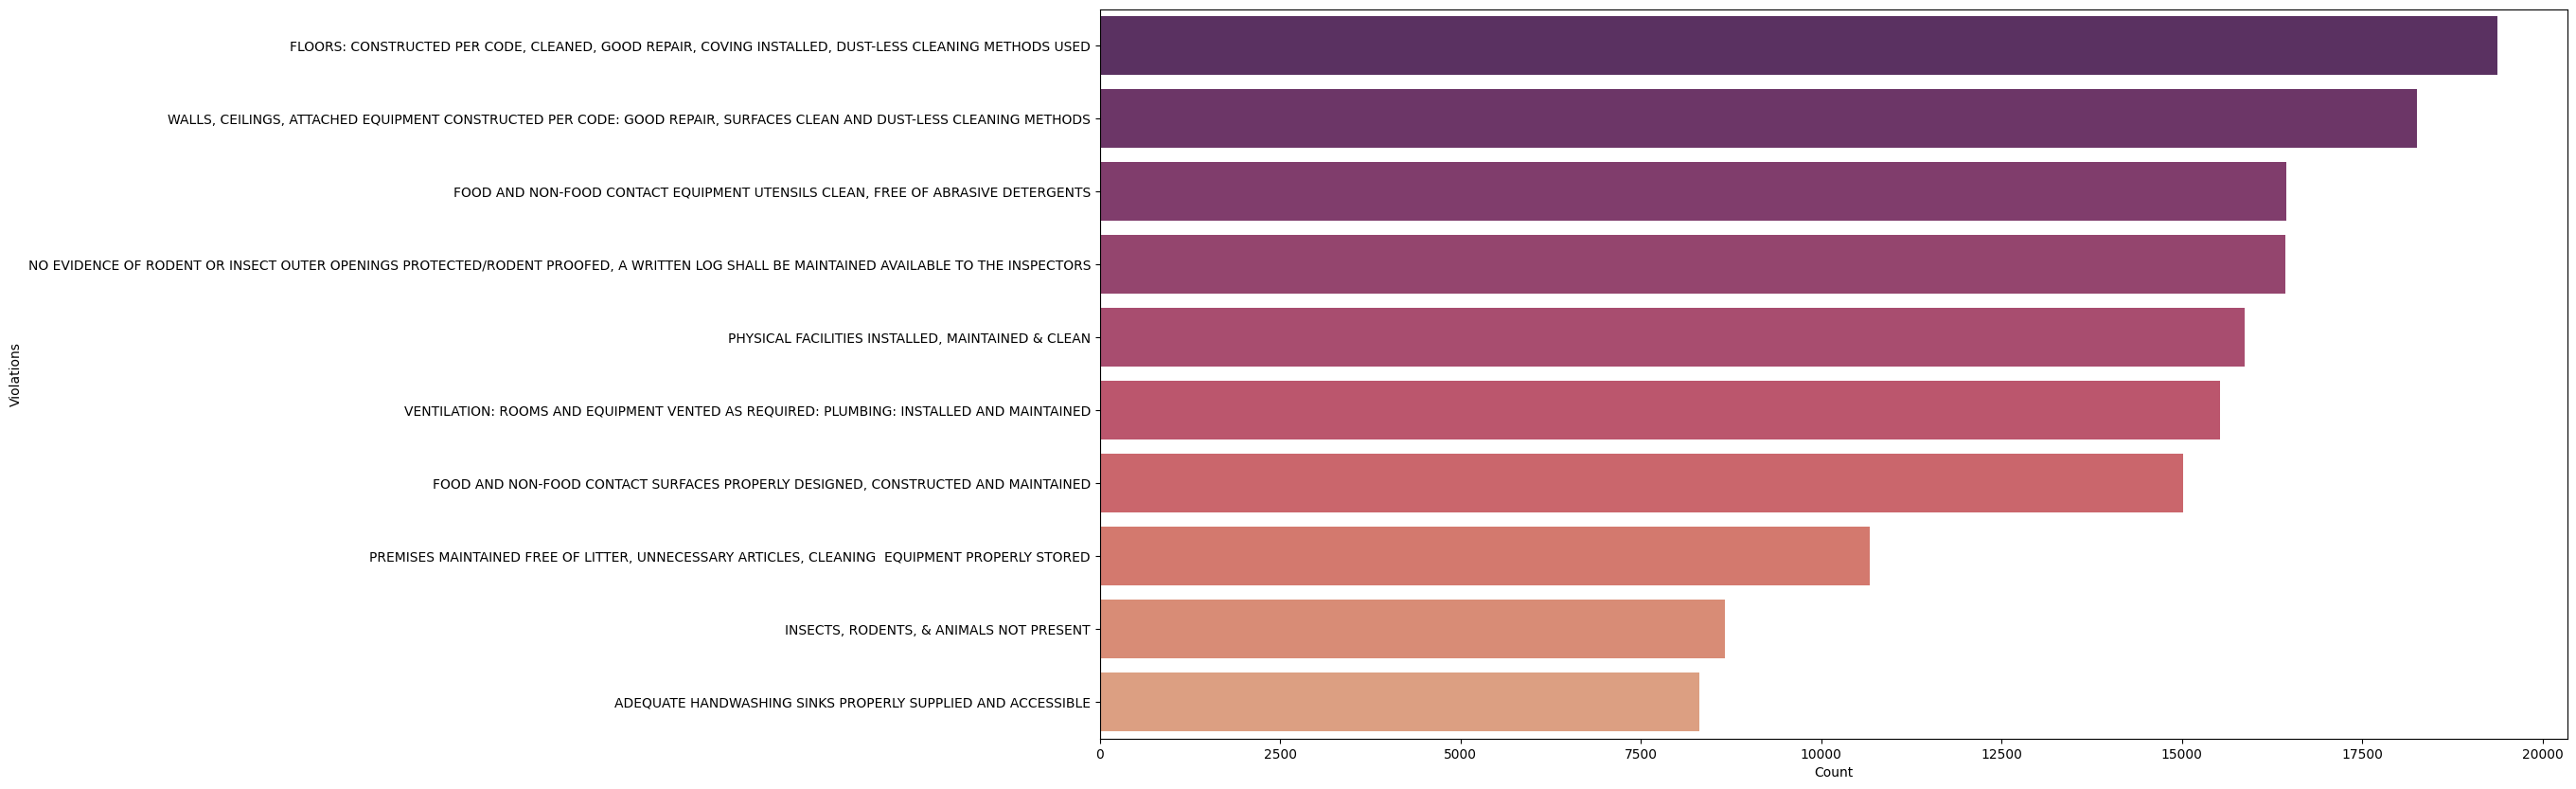

In [235]:
def extract_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = []
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.append(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.append(string)
    return regex_values
description_extract_df = failed_inspection_data["Violations"].apply(extract_descriptions)
description_extract_df = pd.DataFrame(description_extract_df.explode(),columns=["Violations"])
top10 = pd.DataFrame(description_extract_df.value_counts())
top10.reset_index(inplace=True)
top10 = top10.rename(columns = {'index':'Violations','count':'Count'})
top10[:10]
fig,axs = plt.subplots(1,1,figsize=(20,10))
top_violations = sns.barplot(data=top10[:10],x="Count",y="Violations",ax=axs,palette=sns.color_palette("flare",n_colors=10)[::-1])

### Let us now find out the restaurants that are repeat offenders and what their most repeated offenses are

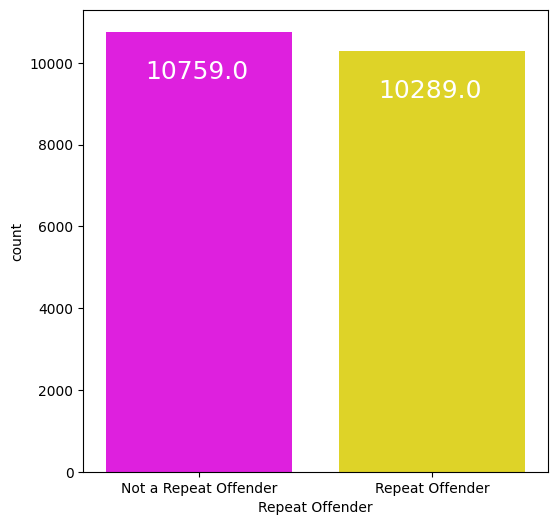

In [244]:
def extract_set_descriptions(violation):
    split_violations = violation.split(sep="|")
    regex_values = set()
    pattern = r"(?<=\d\.).*(?= - Comments)"
    for i in split_violations:
        regex = re.search(pattern,i)
        if regex is None:
            string = i.strip()
            string = re.sub(r"(\d{1,3}. )","",string)
            regex_values.add(string)
        else:
            string  = i[regex.start(0):regex.end(0)].strip()
            regex_values.add(string)
    return list(regex_values)

def return_duplicates(violation_list):
    violation_set  = set()
    dupes = []
    for x in violation_list:
        if x in violation_set:
            dupes.append(x)
        else:
            violation_set.add(x)
    return set(dupes)

repeat_offenders = pd.DataFrame()
repeat_offenders["Custom Key"] = failed_inspection_data["License #"].astype(str) + "-" + failed_inspection_data["DBA Name"] + "-" + failed_inspection_data["Address"]
repeat_offenders["Custom Key"] = repeat_offenders["Custom Key"].str.strip()
repeat_offenders["Violations_List"] = failed_inspection_data["Violations"].apply(extract_set_descriptions)
Violation_list_grouped = pd.DataFrame(repeat_offenders.groupby(["Custom Key"]).agg({"Violations_List":sum}).reset_index())
count_grouped = pd.DataFrame(repeat_offenders.groupby(["Custom Key"]).count().reset_index())
joined_grouped = Violation_list_grouped.merge(count_grouped,on=["Custom Key"])
joined_grouped.columns = ["Custom Key","Violations","Number of Failed Inspections"]
joined_grouped["Repeat Violations"] = joined_grouped["Violations"].apply(return_duplicates)
joined_grouped["Repeat Offender"] = joined_grouped["Number of Failed Inspections"].apply(lambda x: "Repeat Offender" if x>1 else "Not a Repeat Offender")
fig,axs = plt.subplots(1,1,figsize=(6,6))
hist = sns.countplot(data = joined_grouped,x="Repeat Offender",ax=axs,palette=("#FE00FE","#FCED0A"))
for p in axs.patches:
    axs.annotate(f'\n{p.get_height()}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=18)

As we can see the number of restaurants that are repeat offenders (i.e. the restaurants have been inspected more than 1 time) is 

In [245]:
repeat_offender_df = joined_grouped[joined_grouped["Number of Failed Inspections"]>1].copy()
repeat_offender_df["Count of Repeat Violations"] = repeat_offender_df["Repeat Violations"].apply(lambda x: len(x))
repeat_offender_df.drop(["Repeat Offender"],axis=1,inplace=True)
repeat_offender_df.head()


,Custom Key,Violations,Number of Failed Inspections,Repeat Violations,Count of Repeat Violations
3,0.0-ANTIOCH MISSIONARY BAPTIST CHURCH-415 W EN...,"[PREMISES MAINTAINED FREE OF LITTER, UNNECESSA...",2,"{PREMISES MAINTAINED FREE OF LITTER, UNNECESSA...",3
5,0.0-ASSUMPTION BVM CHURCH-2434 S CALIFORNIA AVE,[NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...,3,"{WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCT...",1
6,0.0-BABAS STEAK AND LEMONADE-3407 1/2 W MADISO...,"[FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, P...",2,"{FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, P...",4
22,0.0-COUNTRY CORN-600 E GRAND AVE,[VENTILATION: ROOMS AND EQUIPMENT VENTED AS RE...,2,{VENTILATION: ROOMS AND EQUIPMENT VENTED AS RE...,1
29,0.0-EMELIA OCAMPO-4422 W ARMITAGE AVE,"[PREMISES MAINTAINED FREE OF LITTER, UNNECESSA...",2,"{PREMISES MAINTAINED FREE OF LITTER, UNNECESSA...",12


In [249]:
joined_grouped[joined_grouped["Custom Key"]=="1043638.0-GAS & FOOD-1549 W ROOSEVELT RD"]["Violations"].values

array([list(['PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN', 'PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS', 'INSECTS, RODENTS, & ANIMALS NOT PRESENT', 'PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED', 'WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS', 'OUTSIDE GARBAGE WASTE GREASE AND STORAGE AREA; CLEAN, RODENT PROOF, ALL CONTAINERS COVERED', 'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED'])],
      dtype=object)

In [255]:
repeat_offenders[repeat_offenders["Custom Key"]=="1043638.0-GAS & FOOD-1549 W ROOSEVELT RD"]

,Custom Key,Violations_List
45001,1043638.0-GAS & FOOD-1549 W ROOSEVELT RD,"[PHYSICAL FACILITIES INSTALLED, MAINTAINED & C..."
193514,1043638.0-GAS & FOOD-1549 W ROOSEVELT RD,"[PREMISES MAINTAINED FREE OF LITTER, UNNECESSA..."


In [247]:
x = repeat_offender_df[repeat_offender_df['Count of Repeat Violations']>0]["Custom Key"].values
x.tofile("key.tsv",sep="\n")

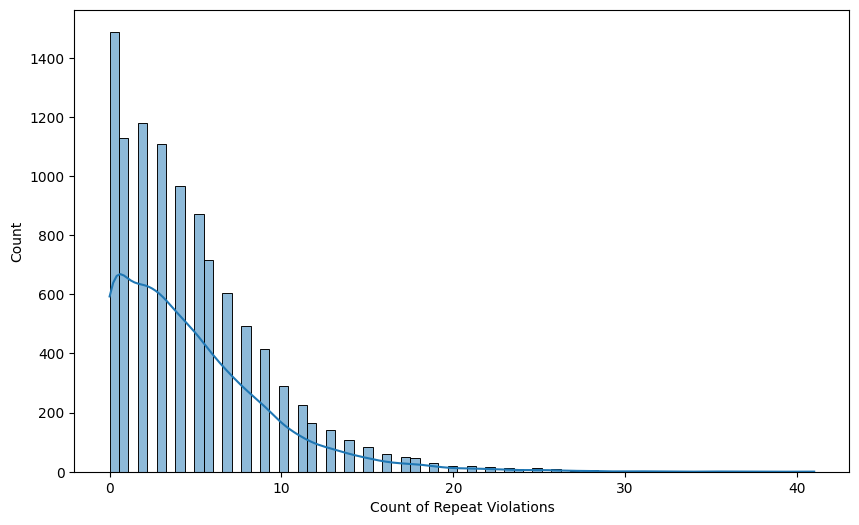

In [193]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
hist = sns.histplot(data = repeat_offender_df,x="Count of Repeat Violations",kde=True,ax=axs)

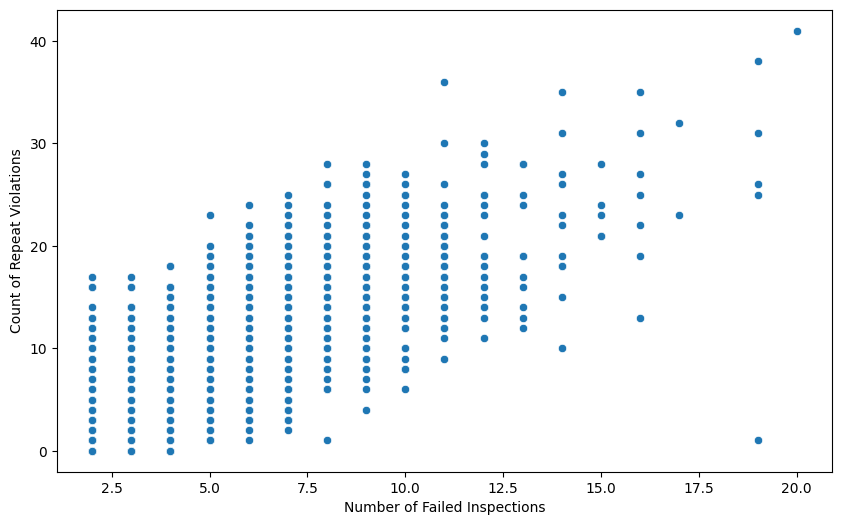

In [194]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
hist = sns.scatterplot(data = repeat_offender_df,y="Count of Repeat Violations",x="Number of Failed Inspections",ax=axs)

In [33]:
closed_restaurant_data = food_inspection_data[(food_inspection_data["Results"]=="Out of Business")]

In [34]:
def No_of_Violations(violations):
    if pd.notnull(violations):
        split_violations = str(violations).split(sep="|")
        return len(split_violations)
    else:
        return 0

In [35]:
closed_restaurant_data["Violations Count"] = closed_restaurant_data["Violations"].apply(No_of_Violations)
closed_restaurant_data

C:\Users\yomaa\AppData\Local\Temp\ipykernel_12076\2180440040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_restaurant_data["Violations Count"] = closed_restaurant_data["Violations"].apply(No_of_Violations)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violations Count
5,2560419,CHARTWELLS,MANSUETO HIGH SCHOOL,2549059.0,HIGH SCHOOL KITCHEN,Risk 1 (High),2911 W W 47TH ST,CHICAGO,IL,60632.0,07/07/2022,Canvass,Out of Business,NaN,NaN,NaN,NaN,0
20,2545896,7-ELEVEN #24606,7-ELEVEN #24606,12892.0,Grocery Store,Risk 2 (Medium),2600 N LINCOLN AVE,CHICAGO,IL,60614.0,12/21/2021,Canvass,Out of Business,NaN,41.928972,-87.653902,"(41.92897165071963, -87.65390175680133)",0
22,2545841,KURAH,KURAH,2202308.0,Restaurant,Risk 1 (High),1355 S MICHIGAN AVE,CHICAGO,IL,60605.0,12/20/2021,Canvass,Out of Business,NaN,41.864249,-87.623934,"(41.864248796634286, -87.62393362748476)",0
29,2545881,LA ROCCIA,LA ROCCIA,10486.0,Restaurant,Risk 1 (High),1909 N LINCOLN AVE,CHICAGO,IL,60614.0,12/10/2021,Canvass,Out of Business,NaN,41.916848,-87.636524,"(41.91684810981031, -87.6365244655254)",0
31,2545186,UNITED CLUB,UNITED CLUB (T1-B6),2464515.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/07/2021,Canvass,Out of Business,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245690,277330,"ARMITAGE BAR & LIQUOR, INC",EL ULTIMO BARCO,36787.0,TAVERN,Risk 3 (Low),3534 W ARMITAGE AVE,CHICAGO,IL,60647.0,07/13/2010,Complaint,Out of Business,NaN,41.917413,-87.714992,"(41.91741305147927, -87.71499192278915)",0
245832,277114,ROLLAPALOOZA CORP.,ROLLAPALOOZA CORP.,1893059.0,NaN,Risk 1 (High),3344 N HALSTED ST,CHICAGO,IL,60657.0,07/07/2010,Canvass,Out of Business,NaN,41.943130,-87.649512,"(41.94312984017461, -87.64951168839137)",0
247835,231327,MOUNTAIN VIEW CHEF INC,MOUNTAIN VIEW CHEF INC,1145427.0,Restaurant,Risk 1 (High),2168-2170 S ARCHER AVE,CHICAGO,IL,60616.0,04/13/2010,Out of Business,Out of Business,NaN,41.853167,-87.634461,"(41.85316719933144, -87.63446102872312)",0
248218,78343,ROBERT EDWARDS,ROBERT EDWARDS,8026.0,NaN,Risk 2 (Medium),2558 E 79TH ST,CHICAGO,IL,60649.0,03/11/2010,Out of Business,Out of Business,NaN,41.751904,-87.561449,"(41.75190389254192, -87.5614493592654)",0


In [36]:
grouped_closed_restaurants = closed_restaurant_data.groupby(["License #","DBA Name","Address"])["Violations Count"].sum().reset_index(inplace=False)
grouped_closed_restaurants

,License #,DBA Name,Address,Violations Count
0,0.0,ALTHEA BY MKC,700 N MICHIGAN AVE,0
1,0.0,BABAS STEAK AND LEMONADE,3407 1/2 W MADISON ST,0
2,0.0,BAR RISTA CAFE,1834 W MONTROSE AVE,0
3,0.0,BBQ SUPPLY,6948 N WESTERN AVE,0
4,0.0,BODY FACTORY NUTRITION,1500 W 51ST ST,2
...,...,...,...,...
20986,3639288.0,CHARTWELLS,2235 N HAMILTON AVE,0
20987,3676025.0,"CERES FOOD GROUP, INC.",8131 S MAY ST,0
20988,3759928.0,ARAMARK,13300 S LANGLEY,0
20989,3760620.0,NEW LIFE ACADEMY,2018 N RICHMOND AVE,0


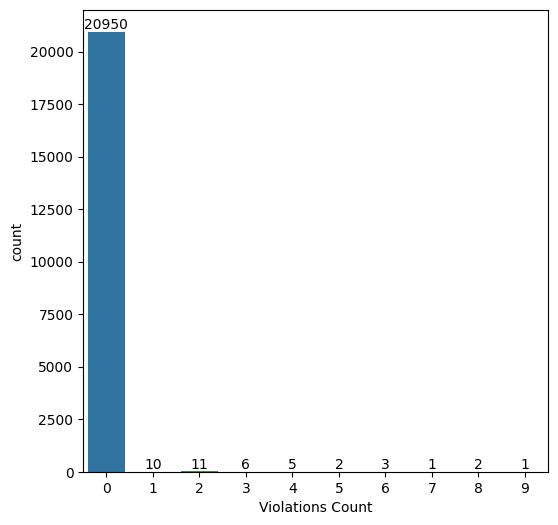

In [37]:
fig,axs = plt.subplots(1,1,figsize=(6,6))
hist = sns.countplot(data=grouped_closed_restaurants,x="Violations Count",ax=axs)
hist = hist.bar_label(hist.containers[0])

As we can see, the majority of "Out of Business" Restaurans have little to no violations.

In [38]:
def extract_descriptions_with_na(violation):
    if str(violation) != "nan":
        split_violations = violation.split(sep="|")
        regex_values = []
        pattern = r"(?<=\d\.).*(?= - Comments)"
        for i in split_violations:
            regex = re.search(pattern,i)
            if regex is None:
                string = i.strip()
                string = re.sub(r"(\d{1,3}. )","",string)
                regex_values.append(string)
            else:
                string  = i[regex.start(0):regex.end(0)].strip()
                regex_values.append(string)
        return regex_values
    else:
        return []

In [73]:
description_extract_df = pd.DataFrame()
description_extract_df["Violations"] = food_inspection_data["Violations"].apply(extract_descriptions_with_na)
description_extract_df["Time"] = food_inspection_data["Inspection Date"]
description_extract_df = description_extract_df.explode("Violations")
description_extract_df = description_extract_df[description_extract_df["Violations"].notna()]

In [64]:
description_extract_df = pd.DataFrame()
description_extract_df["Violations"] = food_inspection_data["Violations"].apply(extract_descriptions_with_na)
description_extract_df = description_extract_df.explode("Violations")
description_extract_df = description_extract_df["Violations"].unique()
description_extract_df.tofile("descriptions.csv",sep="\n")

(892322, 1)

In [74]:
test = description_extract_df["Violations"].unique()
test.tofile("descriptions.csv",sep="\n")

In [67]:
description_extract_df["Year"] = pd.DatetimeIndex(description_extract_df['Time']).year
description_extract_df = description_extract_df.drop(["Time"],axis=1)
description_extract_df

,Violations,Year
36,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPL...",2021
36,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,2021
36,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,2021
36,PROPER HOT HOLDING TEMPERATURES,2021
36,PROPER COOLING METHODS USED; ADEQUATE EQUIPMEN...,2021
...,...,...
251209,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,2010
251209,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,2010
251209,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",2010
251209,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",2010


In [72]:
description_extract_df[description_extract_df["Year"]==2021]["Violations"].unique().tofile("2021.csv",sep="\n")

In [47]:
top5 = pd.DataFrame(description_extract_df["Violations"].value_counts())
top5.reset_index(inplace=True)
top5.columns = ["Violations","Count"]
top5[:5]

,Violations,Count
0,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",71794
1,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",64783
2,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,62915
3,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,54851
4,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,54197


In [57]:
description_extract_agg = pd.DataFrame(description_extract_df.groupby(["Year","Violations"]).size())
description_extract_agg.reset_index(inplace=True)
description_extract_agg[description_extract_agg["Year"]==2022].to_csv("2022.csv")
# selected_violations = description_extract_agg[description_extract_agg["Violations"].isin(top5[:5]["Violations"].values)]
# selected_violations.columns = ["Year","Violations","Count"]
# selected_violations
# selected_violations_pivot = selected_violations.pivot(index="Year",columns="Violations",values="Count")

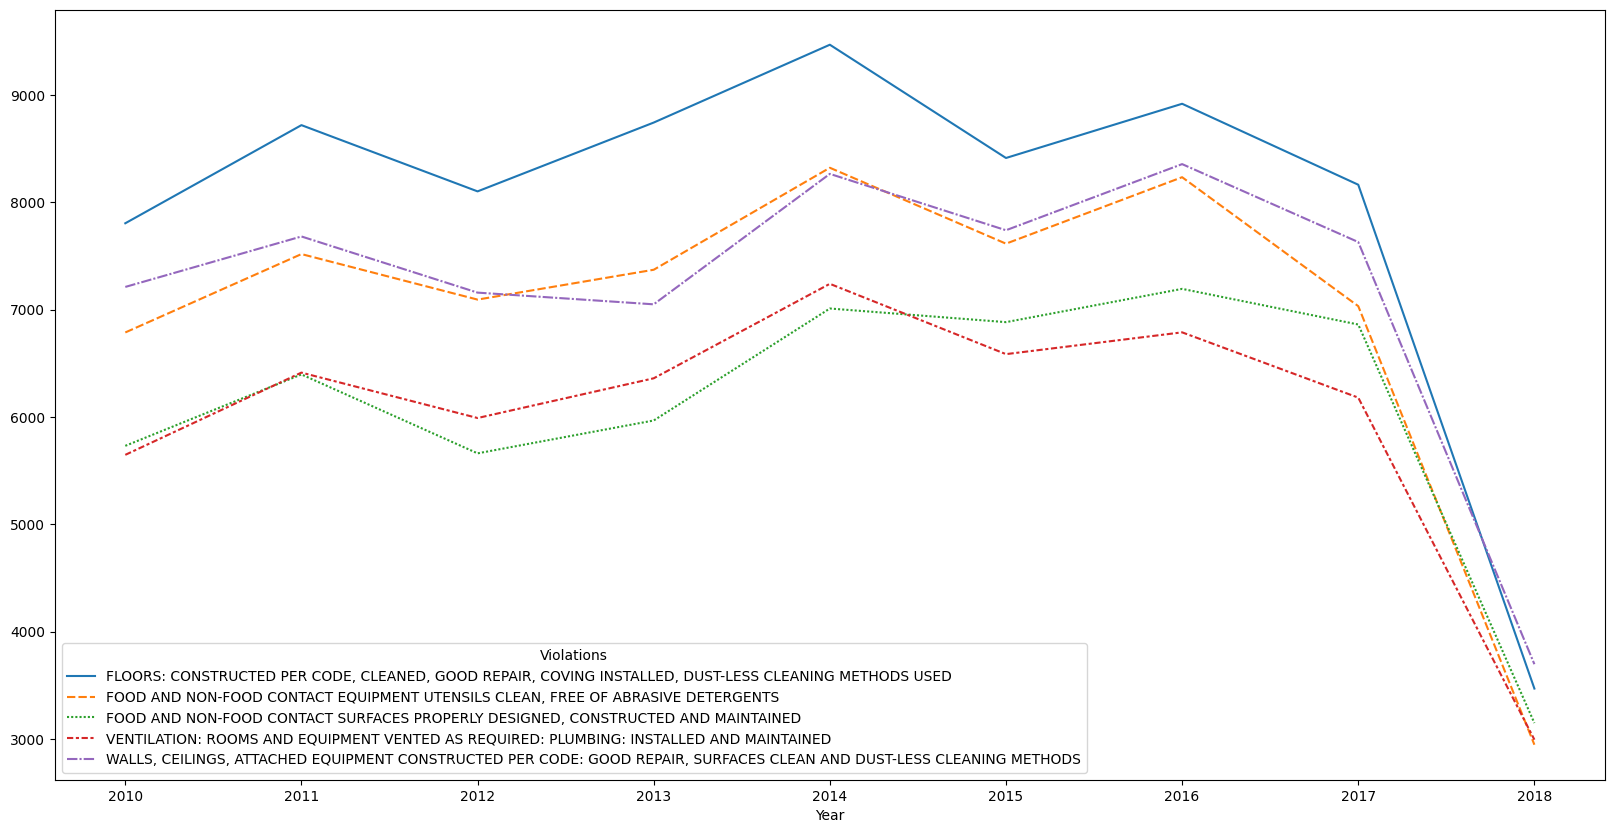

In [51]:
fig,axs = plt.subplots(1,1,figsize=(20,10))
lines = sns.lineplot(data=selected_violations_pivot,ax=axs)